In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
from bisect import bisect_left
import scipy

In [2]:
prices = pd.read_csv("DailyPrices.csv", index_col=0)
returns = pd.read_csv("DailyReturn.csv", index_col=0)

# Question 1

Use the daily return data for the stocks provided to calculate the exponentially weighted covariance matrix and perform the PCA.

In [3]:
# Generate the exponential weights and covariance matrix.
def expWeights(n, lambd):
    weights = np.zeros(n)
    for i in range(1, n+1):
        weights[i-1] = (1-lambd) * (lambd**(i-1))
    normWeights = weights / np.sum(weights)
    return normWeights[::-1]

def expCovMat(data, weights):
    normData = data - data.mean()
    return np.dot(data.T, np.diag(weights) @ data)
    
    
    

In [4]:
weights = expWeights(returns.shape[0], 0.5)
cov = expCovMat(returns, weights)

Reference: the implementation process of PCA uses the resource from this link---
https://www.askpython.com/python/examples/principal-component-analysis.

In [5]:
# Perform the PCA
def PCA(cov):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    
    sortedIndex = np.argsort(eigenvalues)[::-1]
    sortedEigenvalues = eigenvalues[sortedIndex]
    sortedEigenvectors = eigenvectors[:,sortedIndex]
    
    explain = sortedEigenvalues / sortedEigenvalues.sum()
    cumExplain = explain.cumsum()
    cumExplain[-1] = 1
    
    return cumExplain

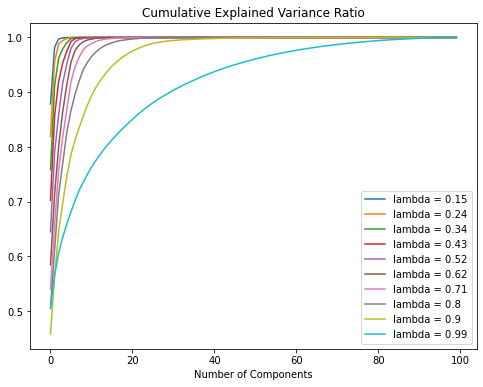

In [7]:
lambdas = np.linspace(0.15, 0.99, 10)

plt.figure(figsize=(8, 6))
for i, lambd in enumerate(lambdas):
    lambd = round(lambd, 2)
    weights = expWeights(returns.shape[0], lambd)
    cov = expCovMat(returns, weights)
    cumExplained = PCA(cov)
    plt.plot(np.arange(returns.shape[1]), cumExplained[:returns.shape[1]], label=f"lambda = {lambd}")

plt.xlabel('Number of Components')
plt.title("Cumulative Explained Variance Ratio")
plt.legend()
plt.savefig("PCA.png")
plt.show()

# Question 2 

Implement the chol_psd() and near_psd(), and implement Higham's 2002 nearest psd correlation function.

In [8]:
def chol_psd(root, a):
    n = a.shape[1]
    
    for j in range(n):
        s = 0.
        if j > 0:
            s = root[j, :j] @ root[j, :j].T
        diag = a[j, j] - s
        if diag <= 0 and diag >= -1e-5:
            diag = 0.
        root[j, j] = np.sqrt(diag)
        
        if root[j, j] == 0.:
            root[j, j:n-1] = 0.
        else:
            for i in range(j+1, n):
                s = root[i,:j] @ root[j,:j].T
                root[i,j] = (a[i,j] - s) / root[j,j]
    
    return root

def near_psd(a, epsilon=0.):
    n = a.shape[1]
    invSD = None
    out = copy.deepcopy(a)
    diagSum = np.sum(np.isclose(1.0, np.diag(out)))
    
    if diagSum != n:
        invSD = np.diag(1. / np.sqrt(np.diag(out)))
        out = invSD @ out @ invSD
        
    eigvals, eigvecs = np.linalg.eigh(out)
    eigvals = np.maximum(eigvals, epsilon)
    T = 1.0 / (np.square(eigvecs) @ eigvals)
    T = np.diagflat(np.sqrt(T))
    l = np.diag(np.sqrt(eigvals))
    B = T @ eigvecs @ l
    out = B @ B.T

    if invSD != None:
        invSD = np.diag(1. / np.diag(invSD))
        out = invSD @ out @ invSD

    return out

In [9]:
def frobenius_norm(matrix):
    return np.sqrt(np.square(matrix).sum())

def projection_u(matrix):
    res = copy.deepcopy(matrix)
    np.fill_diagonal(res, 1.0)
    return res

def projection_s(matrix, epsilon=1e-9):
    eigvals, eigvecs = np.linalg.eigh(matrix)
    eigvals = np.maximum(eigvals, epsilon)
    return eigvecs @ np.diag(eigvals) @ eigvecs.T

# Higham
def higham_psd(a, tol=1e-9):
    s = 0.0
    y = a
    prev_gamma = np.inf

    while True:
        r = y - s
        x = projection_s(r)
        s = x - r
        y = projection_u(x)
        gamma = frobenius_norm(y - a)

        if abs(gamma - prev_gamma) < tol:  
            break
        prev_gamma = gamma

    return y
     

In [15]:
def nonPSDMatGen(n):
    sigma = np.matrix(np.full((n, n), 0.9))
    np.fill_diagonal(sigma, 1.)
    sigma[1, 0] = 0.7357
    sigma[0, 1] = 0.7357
    
    return sigma

In [11]:
def is_psd(matrix):
    eigvals = np.linalg.eigvals(matrix)
    return np.all(eigvals >= 0)

In [16]:
sigma = nonPSDMatGen(500)

In [17]:
print(is_psd(near_psd(sigma)))
print(is_psd(higham_psd(sigma)))

True
True


In [24]:
print(frobenius_norm(near_psd(sigma)-sigma))
print(frobenius_norm(higham_psd(sigma)-sigma))

0.6275226557662099
0.08964799722863047


In [18]:
def nearPsdRuntime(n):
    sigma = nonPSDMatGen(n)
    start_t = time.time()
    near_psd_matrix = near_psd(sigma)
    end_t = time.time()
    
    return end_t - start_t

def highamPsdRuntime(n):
    sigma = nonPSDMatGen(n)
    start_t = time.time()
    near_psd_matrix = higham_psd(sigma)
    end_t = time.time()
    
    return end_t - start_t

In [19]:
N = np.linspace(100, 1000, 10, dtype=np.int32)
tNear = []
tHigham = []

In [20]:
for i in range(len(N)):
    nearT = nearPsdRuntime(N[i])
    highamT = highamPsdRuntime(N[i])
    tNear.append(nearT)
    tHigham.append(highamT)

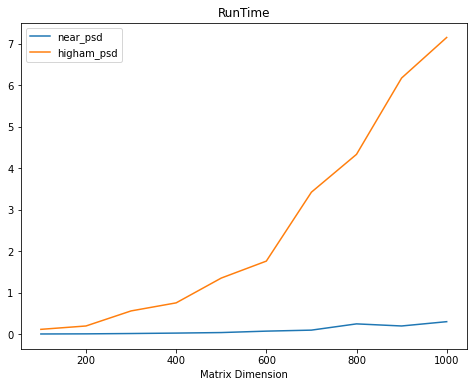

In [23]:
plt.figure(figsize=(8, 6))
plt.plot(N, tNear, label='near_psd')
plt.plot(N, tHigham, label='higham_psd')
plt.xlabel('Matrix Dimension')
plt.title("RunTime")
plt.legend()
plt.savefig("psd.png")
plt.show()

# Question 3

In [24]:
def multVarNormGen(cov, n=25000):
    root = np.full(cov.shape, 0.0)
    return chol_psd(root, cov) @ np.random.normal(size=(cov.shape[0], n))
def var(cov):
    return np.diag(cov)
def corr(cov):
    std = np.diag(1 / np.sqrt(var(cov)))
    return std @ cov @ std.T
def cov(var, cor):
    std = np.sqrt(var)
    return np.diag(std) @ cor @ np.diag(std).T

In [25]:
ewCov = expCovMat(returns, expWeights(returns.shape[0], 0.97))
normCov = np.cov(returns.T)

norm_corr_norm_var = cov(var(normCov), corr(normCov))
ew_corr_norm_var = cov(var(normCov), corr(ewCov))
norm_corr_ew_var = cov(var(ewCov), corr(normCov))
ew_corr_ew_var = cov(var(ewCov), corr(ewCov))

In [30]:
def simulationPCA(cov, percent, n=25000):
    eigvals, eigvecs = np.linalg.eigh(cov)

    sortedIndex = np.argsort(eigvals)[::-1]
    sortedEigvals = eigvals[sortedIndex]
    sortedEigvecs = eigvecs[:,sortedIndex]

    explain = sortedEigvals / sortedEigvals.sum()
    cumExplain = explain.cumsum()
    cumExplain[-1] = 1

    idx = bisect_left(cumExplain, percent)

    explainedVals = np.clip(sortedEigvals[:idx + 1], 0, np.inf)
    explainedVecs = sortedEigvecs[:, :idx + 1]

    B = explainedVecs @ np.diag(np.sqrt(explainedVals))
    r = np.random.randn(B.shape[1], n)
    return B @ r

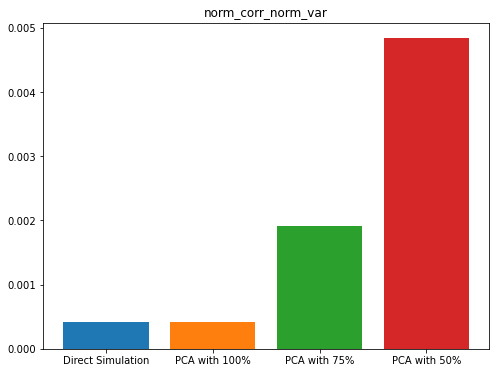

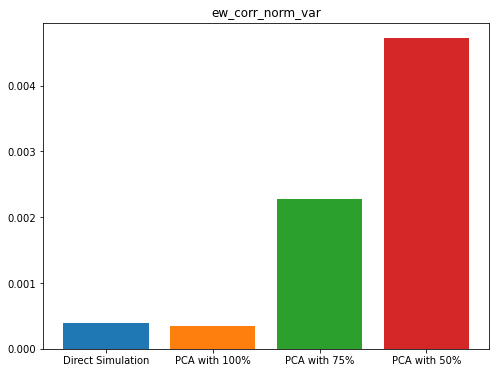

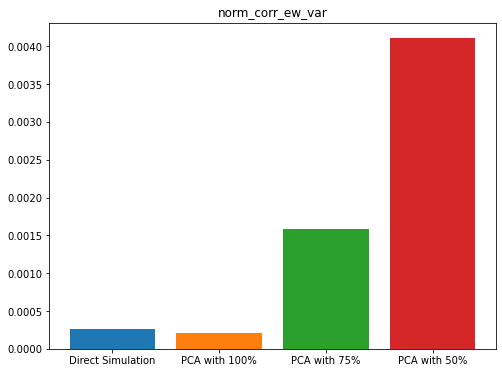

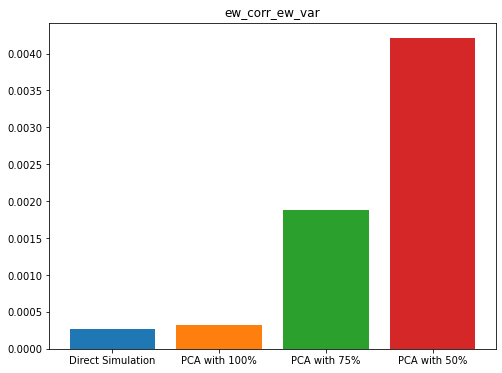

In [31]:
covs = [norm_corr_norm_var, ew_corr_norm_var, norm_corr_ew_var, ew_corr_ew_var]
title = ["norm_corr_norm_var", "ew_corr_norm_var", "norm_corr_ew_var", "ew_corr_ew_var"]
for i in range(len(covs)):
    plt.figure(figsize=(8, 6))
    plt.title(title[i])
    cov = covs[i]
    
    start = time.time()
    data1 = multVarNormGen(cov)
    end1 = time.time() - start
    
    start = time.time()
    data2 = simulationPCA(cov, 1)
    end2 = time.time() - start
    
    start = time.time()
    data3 = simulationPCA(cov, 0.75)
    end3 = time.time() - start
    
    start = time.time()
    data4 = simulationPCA(cov, 0.5)
    end4 = time.time() - start
    
    plt.bar("Direct Simulation", frobenius_norm(cov-np.cov(data1)))
    plt.bar("PCA with 100%", frobenius_norm(cov-np.cov(data2)))
    plt.bar("PCA with 75%", frobenius_norm(cov-np.cov(data3)))
    plt.bar("PCA with 50%", frobenius_norm(cov-np.cov(data4)))
    
#     plt.bar("Direct Simulation",end1)
#     plt.bar("PCA with 100%",end2)
#     plt.bar("PCA with 75%",end3)
#     plt.bar("PCA with 50%",end4)
    plt.savefig("PCA{}.png".format(i))
    plt.show()

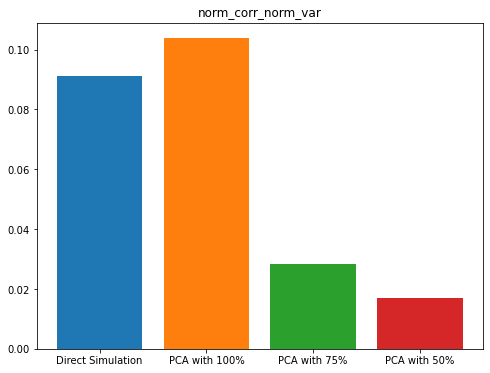

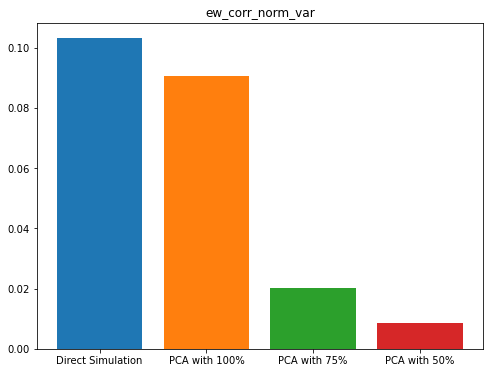

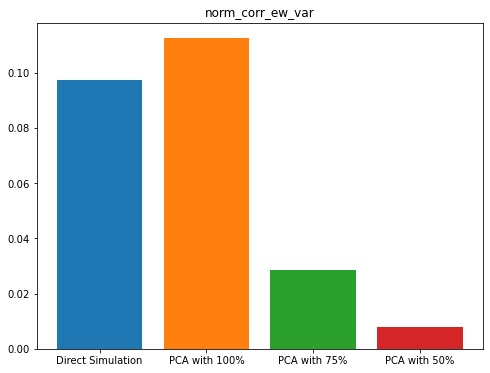

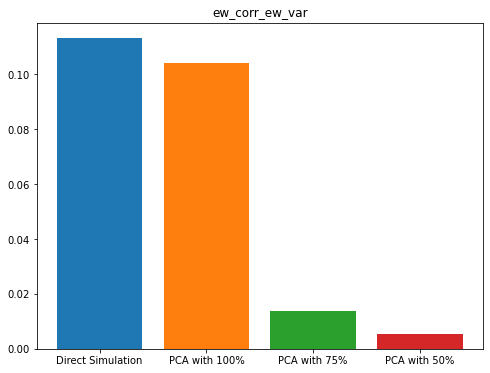

In [32]:
for i in range(len(covs)):
    plt.figure(figsize=(8, 6))
    plt.title(title[i])
    cov = covs[i]
    
    start = time.time()
    data1 = multVarNormGen(cov)
    end1 = time.time() - start
    
    start = time.time()
    data2 = simulationPCA(cov, 1)
    end2 = time.time() - start
    
    start = time.time()
    data3 = simulationPCA(cov, 0.75)
    end3 = time.time() - start
    
    start = time.time()
    data4 = simulationPCA(cov, 0.5)
    end4 = time.time() - start
    
    plt.bar("Direct Simulation",end1)
    plt.bar("PCA with 100%",end2)
    plt.bar("PCA with 75%",end3)
    plt.bar("PCA with 50%",end4)
    
    plt.savefig("time{}.png".format(i))
    
    plt.show()